In [ ]:
# --- Notebook Cell 1 ---
from pathlib import Path
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Fixed dB window used when you generated the cache.
# If you used librosa.power_to_db(S, ref=np.max), values are usually in [-80, 0].
DB_MIN, DB_MAX = -80.0, 0.0

# Tiling choice for the two channels: "v" (vertical stack) or "h" (horizontal concat)
TILE = "v"

# Reproducibility
random.seed(1337)
np.random.seed(1337)

In [10]:
# --- Notebook Cell 2 ---
def load_manifest(manifest_csv: str) -> pd.DataFrame:
    df = pd.read_csv(manifest_csv)
    df["label"] = df["label"].astype(str).str.strip().str.lower()
    return df

def choose_one_per_class(df: pd.DataFrame) -> pd.DataFrame:
    # sample one row per label (deterministic by sorting)
    picked = []
    for label, grp in sorted(df.groupby("label"), key=lambda x: x[0]):
        picked.append(grp.sample(n=1, random_state=1337).iloc[0])
    return pd.DataFrame(picked).reset_index(drop=True)

def db_to_uint8(img_db: np.ndarray, db_min: float, db_max: float) -> np.ndarray:
    """Map dB image to uint8 [0,255] with fixed range for consistent appearance."""
    x = np.clip(img_db, db_min, db_max)
    x = (x - db_min) / (db_max - db_min + 1e-12)
    return (x * 255.0).round().astype(np.uint8)

def make_display_image(mel_2c: np.ndarray, tile: str = "v") -> np.ndarray:
    """
    mel_2c: (2, F, T) float32 dB
    Returns a 2D uint8 image:
      - vertical: shape (2F, T)
      - horizontal: shape (F, 2T)
    """
    assert mel_2c.ndim == 3 and mel_2c.shape[0] == 2, "Expected (2, F, T)"
    left_u8  = db_to_uint8(mel_2c[0], DB_MIN, DB_MAX)   # (F, T)
    right_u8 = db_to_uint8(mel_2c[1], DB_MIN, DB_MAX)   # (F, T)
    if tile == "h":
        return np.concatenate([left_u8, right_u8], axis=1)
    else:
        return np.concatenate([left_u8, right_u8], axis=0)

def load_npy(path: str) -> np.ndarray:
    # (2, F, T) float32, as saved by precache_mels.py
    return np.load(path)

In [13]:

MEL_MANIFEST = "manifests/irmas_mels.csv" # update accordingly
df = load_manifest(MEL_MANIFEST)

classes = sorted(df["label"].unique())   # should be 11 IRMAS classes
print(f"Found {len(classes)} classes:", classes)

samples_df = choose_one_per_class(df)
samples_df

Found 11 classes: ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']


,filepath,label
0,/Users/hughsignoriello/Developer/ML-based-anal...,cel
1,/Users/hughsignoriello/Developer/ML-based-anal...,cla
2,/Users/hughsignoriello/Developer/ML-based-anal...,flu
3,/Users/hughsignoriello/Developer/ML-based-anal...,gac
4,/Users/hughsignoriello/Developer/ML-based-anal...,gel
5,/Users/hughsignoriello/Developer/ML-based-anal...,org
6,/Users/hughsignoriello/Developer/ML-based-anal...,pia
7,/Users/hughsignoriello/Developer/ML-based-anal...,sax
8,/Users/hughsignoriello/Developer/ML-based-anal...,tru
9,/Users/hughsignoriello/Developer/ML-based-anal...,vio


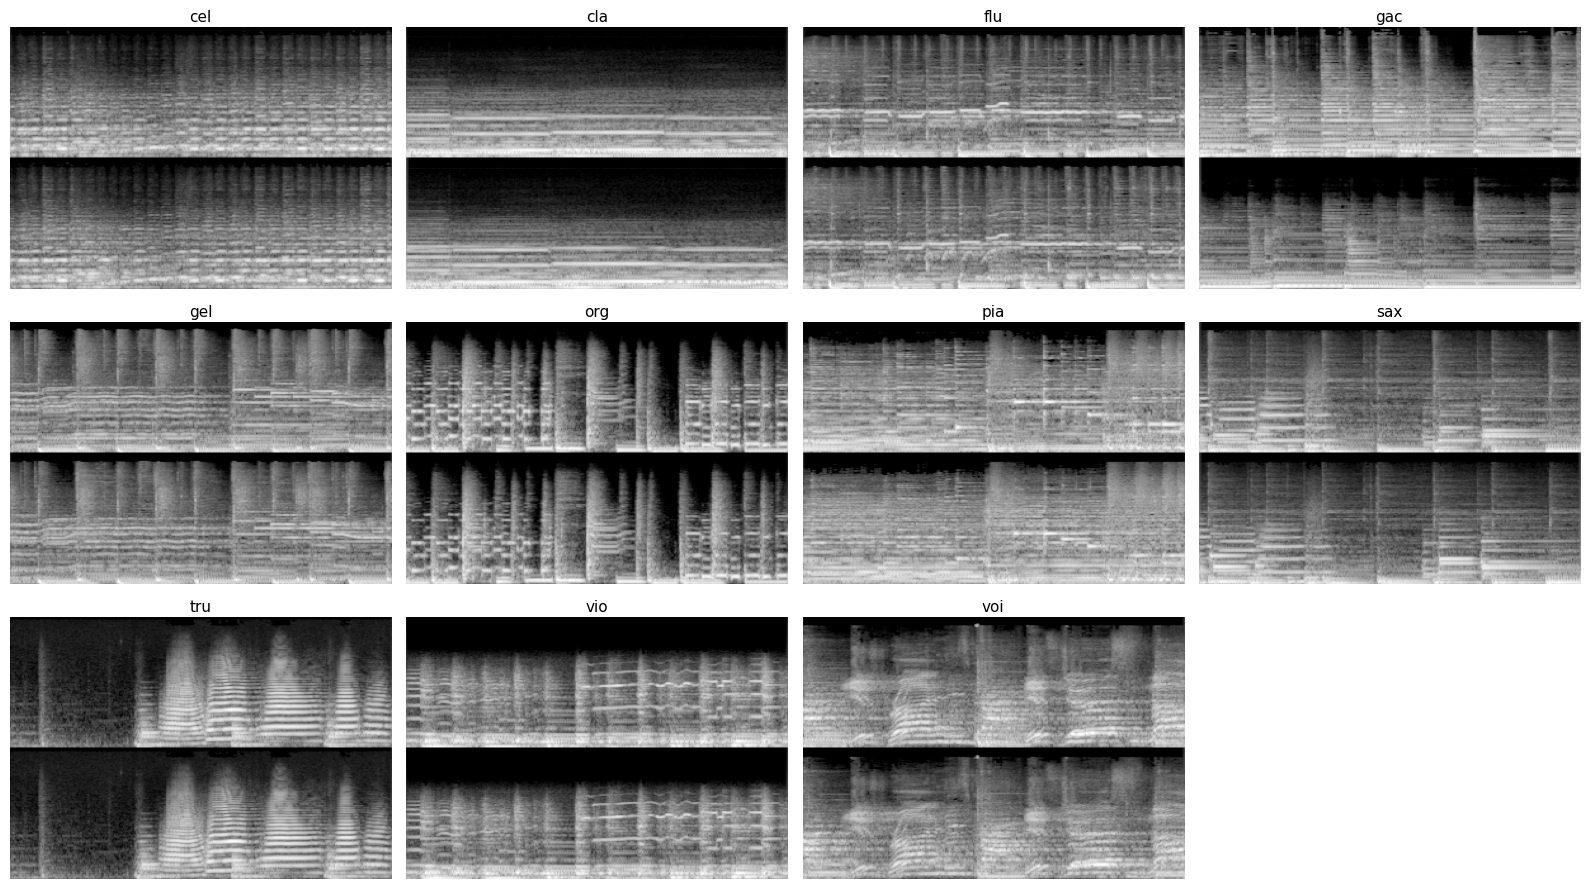

In [14]:
# --- Notebook Cell 4 ---
# Grid layout: 4 columns × ceil(11/4) rows
N = len(samples_df)
COLS = 4
ROWS = math.ceil(N / COLS)

# Make a figure; height per row tuned for mel aspect (taller if vertical tiling)
fig_h_per_row = 3.0 if TILE == "v" else 2.2
fig_w = 16
fig_h = fig_h_per_row * ROWS

fig, axes = plt.subplots(ROWS, COLS, figsize=(fig_w, fig_h))
axes = np.atleast_2d(axes)

for i in range(ROWS * COLS):
    r, c = divmod(i, COLS)
    ax = axes[r, c]
    ax.axis("off")
    if i >= N:  # blank cell
        continue

    row = samples_df.iloc[i]
    path = row["filepath"]
    label = row["label"]

    mel = load_npy(path)                 # (2, F, T)
    img = make_display_image(mel, TILE)  # (H, W)

    # Display: mel frequency axis up; flip vertically so low freqs at bottom
    ax.imshow(img[::-1, :], aspect="auto", cmap="gray")
    ax.set_title(label, fontsize=11, pad=4)

plt.tight_layout()
plt.show()